In [19]:
import ast
import pickle
from collections import Counter
from pathlib import Path
from time import gmtime, strftime
from typing import Any, Iterable, Optional, Union

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm.notebook import tqdm

#from preprocess_functions import build_tree, extract_keys, map_targets

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

In [ ]:
COLAB_DIR = Path('/content/drive/MyDrive')
KAGGLE_DIR = Path('/kaggle/input')
LOCAL_DIR = Path('./')

try:
    import google.colab

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

try:
    import kaggle_secrets

    IN_KAGGLE = True
except ImportError:
    IN_KAGGLE = False

if IN_COLAB:
    DATA_DIR = COLAB_DIR / 'data'
    MODELS_DIR = COLAB_DIR / 'models'
elif IN_KAGGLE:
    DATA_DIR = KAGGLE_DIR
    MODELS_DIR = KAGGLE_DIR
else:
    DATA_DIR = LOCAL_DIR / 'data'
    MODELS_DIR = LOCAL_DIR / 'models'

In [6]:
TWEETS_CSV = DATA_DIR / 'tweets-dataset-for-cyberattack-detection' / 'tweets_final.csv'

In [7]:
filter_df = pd.read_csv(filepath_or_buffer=TWEETS_CSV)
filter_df.dropna(subset=['relevant'])

print(f"There are {filter_df.shape[0]} tweets")
filter_df.head()

There are 21368 tweets


_id                       date  \
0  b'5b88752abb325e65390af240'  2018-08-30 22:52:25+00:00   
1  b'5b8875d5bb325e65a22cf81b'  2018-08-30 22:55:15+00:00   
2  b'5b88768dbb325e65fa7e78e3'  2018-08-30 22:58:20+00:00   
3  b'5b8876f9bb325e65fa7e78e4'  2018-08-30 23:00:08+00:00   
4  b'5b8876f9bb325e65fa7e78e5'  2018-08-30 23:00:09+00:00   

                    id  relevant  \
0  1035299228984041472     False   
1  1035299941932036096     False   
2  1035300715470757889     False   
3  1035301167952211969      True   
4  1035301173178249217      True   

                                                text  \
0  Best way to build empathy is through honesty a...   
1  Cryptocurrency Scams Replacing Ransomware as A...   
2  Cryptocurrency Scams Replacing Ransomware as A...   
3  Protect  your customers  access Prestashop Ant...   
4  Data leak from Huazhu Hotels may affect 130 mi...   

                                               tweet           type  \
0  {'created_at': 'Thu Aug 30 22:52:25 +0000 2018...  vulnerability   
1  {'created_at': 'Thu Aug 30 22:55:15 +0000 2018...     ransomware   
2  {'created_at': 'Thu Aug 30 22:58:20 +0000 2018...     ransomware   
3  {'created_at': 'Thu Aug 30 23:00:08 +0000 2018...           ddos   
4  {'created_at': 'Thu Aug 30 23:00:09 +0000 2018...           leak   

                                              watson  annotation  \
0  {'usage': {'text_units': 1, 'text_characters':...  irrelevant   
1  {'usage': {'text_units': 1, 'text_characters':...    business   
2  {'usage': {'text_units': 1, 'text_characters':...    business   
3  {'usage': {'text_units': 1, 'text_characters':...      threat   
4  {'usage': {'text_units': 1, 'text_characters':...      threat   

                                                urls  \
0                                                 []   
1                         ['https://ubm.io/2MCQwfg']   
2  ['http://quantus.biz/security/2018/08/30/crypt...   
3  ['http://addons.prestashop.com/en/23513-anti-d...   
4  ['http://www.hotelmanagement.net/tech/data-lea...   

                                     destination_url valid_certificate  
0                                                NaN               NaN  
1      https://www.darkreading.com/endpoint-security             False  
2                     http://www.quantusintel.group/              True  
3  https://addons.prestashop.com/en/23513-anti-dd...              True  
4  http://www.hotelmanagement.net/tech/data-leak-...              True

In [8]:
X_train_val, X_test = train_test_split(
    filter_df,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=filter_df['relevant']
)

X_train_val.shape, X_test.shape

((17094, 12), (4274, 12))

In [13]:
with open(DATA_DIR / 'tweets-dataset' / 'filter_train.csv', 'wb') as f:
    X_train_val.to_csv(path_or_buf=f)

with open(DATA_DIR / 'tweets-dataset' / 'filter_test.csv', 'wb') as f:
    X_test.to_csv(path_or_buf=f)

In [14]:
X_train_val = pd.read_csv(filepath_or_buffer=DATA_DIR / 'tweets-dataset' / 'filter_train.csv')
X_test = pd.read_csv(filepath_or_buffer=DATA_DIR / 'tweets-dataset' / 'filter_test.csv')

X_train_val.shape, X_test.shape

((17094, 13), (4274, 13))

In [21]:
def build_tree(categories: list[dict]) -> dict:
    """
    Build a tree-like structure (nested dictionary) from category labels.

    Parameters
    ----------
    categories
        A list of categories, where each category has a 'label' key that contains a path-like string.

    Returns
    -------
    tree
        A nested dictionary representing the tree structure.
    """
    tree = {}

    for category in categories:
        current = tree

        for part in category['label'].strip('/').split('/'):
            current = current.setdefault(part, {})

    return tree
    
def extract_keys(d: Union[dict, object], path: Optional[Iterable] = None) -> list:
    """
    Recursively extract keys from a dictionary, building paths as a list.

    Parameters
    ----------
    d
        The dictionary to extract keys from.
    path
        A list to accumulate the path, default is None.

    Returns
    -------
    path
        A list of paths representing keys in the dictionary.
    """
    if path is None:
        path = []

    if isinstance(d, dict):
        for key, value in d.items():
            path = extract_keys(d=value, path=path + [key])
    else:
        path = [d]

    return path

def map_targets(watson_list, fix_targets):
    targets = set(fix_targets.keys()) & set(watson_list)
    mapped_targets = {fix_targets[category] for category in targets}
    return list(mapped_targets) if mapped_targets else ['other']

In [30]:
FIX_TARGETS = {
    'computer security': 'computer security',
    'operating systems': 'operating systems',
    'software': 'software',
    'programming languages': 'software',
    'hardware': 'hardware',
    'electronic components': 'hardware',
    'networking': 'networking',
    'internet technology': 'networking',
    'network security': 'network security',
    'antivirus and malware': 'antivirus and malware',
    'mac os': 'mac os',
    'windows': 'windows',
    'unix': 'unix',
    'linux': 'linux',
    'databases': 'databases',
    'computer': 'computer',
    'computer components': 'computer components',
    'computer networking': 'computer networking',
    'servers': 'servers',
    'portable computer': 'portable computer',
    'desktop computer': 'desktop computer',
    'router': 'router',
    'wireless technology': 'wireless technology'
}

categories_df = (
    pd.read_csv(filepath_or_buffer=TWEETS_CSV)
    .assign(
        tweet=lambda df: df['tweet'].apply(func=ast.literal_eval),
        watson=lambda df: df['watson'].apply(func=ast.literal_eval)
        .apply(func=lambda x: x.get('categories', []))
        .apply(func=build_tree),
        watson_list=lambda df: df['watson'].apply(func=extract_keys),
        target=lambda df: df['watson_list'].apply(func=map_targets, args=(FIX_TARGETS,))
    )
    #.query(expr='relevant == True')
)
mask = ['other' in target_i for target_i in categories_df['target']]
categories_df_temp = categories_df[mask]
categories_df_temp = categories_df_temp[categories_df_temp['relevant'] == False]
categories_df = categories_df.loc[list(set(categories_df.index) - set(categories_df_temp.index))]
categories_df = categories_df.reset_index(drop=True)

print(f"There are {categories_df.shape[0]} tweets")
categories_df.head()

There are 15610 tweets


_id                       date  \
0  b'5b88752abb325e65390af240'  2018-08-30 22:52:25+00:00   
1  b'5b8875d5bb325e65a22cf81b'  2018-08-30 22:55:15+00:00   
2  b'5b88768dbb325e65fa7e78e3'  2018-08-30 22:58:20+00:00   
3  b'5b8876f9bb325e65fa7e78e4'  2018-08-30 23:00:08+00:00   
4  b'5b8876f9bb325e65fa7e78e5'  2018-08-30 23:00:09+00:00   

                    id  relevant  \
0  1035299228984041472     False   
1  1035299941932036096     False   
2  1035300715470757889     False   
3  1035301167952211969      True   
4  1035301173178249217      True   

                                                text  \
0  Best way to build empathy is through honesty a...   
1  Cryptocurrency Scams Replacing Ransomware as A...   
2  Cryptocurrency Scams Replacing Ransomware as A...   
3  Protect  your customers  access Prestashop Ant...   
4  Data leak from Huazhu Hotels may affect 130 mi...   

                                               tweet           type  \
0  {'created_at': 'Thu Aug 30 22:52:25 +0000 2018...  vulnerability   
1  {'created_at': 'Thu Aug 30 22:55:15 +0000 2018...     ransomware   
2  {'created_at': 'Thu Aug 30 22:58:20 +0000 2018...     ransomware   
3  {'created_at': 'Thu Aug 30 23:00:08 +0000 2018...           ddos   
4  {'created_at': 'Thu Aug 30 23:00:09 +0000 2018...           leak   

                                              watson  annotation  \
0  {'science': {'social science': {'philosophy': ...  irrelevant   
1  {'technology and computing': {'computer securi...    business   
2  {'technology and computing': {'computer securi...    business   
3  {'technology and computing': {'internet techno...      threat   
4  {'travel': {'hotels': {}}, 'home and garden': ...      threat   

                                                urls  \
0                                                 []   
1                         ['https://ubm.io/2MCQwfg']   
2  ['http://quantus.biz/security/2018/08/30/crypt...   
3  ['http://addons.prestashop.com/en/23513-anti-d...   
4  ['http://www.hotelmanagement.net/tech/data-lea...   

                                     destination_url valid_certificate  \
0                                                NaN               NaN   
1      https://www.darkreading.com/endpoint-security             False   
2                     http://www.quantusintel.group/              True   
3  https://addons.prestashop.com/en/23513-anti-dd...              True   
4  http://www.hotelmanagement.net/tech/data-leak-...              True   

                                         watson_list  \
0  [science, social science, philosophy, ethics, ...   
1  [technology and computing, computer security, ...   
2  [technology and computing, computer security, ...   
3  [technology and computing, internet technology...   
4  [travel, hotels, home and garden, home improve...   

                                              target  
0              [network security, computer security]  
1  [computer, computer security, hardware, antivi...  
2  [computer, computer security, hardware, antivi...  
3  [software, networking, computer security, anti...  
4                                            [other]

Target Frequencies:
computer security: 9216
antivirus and malware: 5854
software: 5214
network security: 4321
hardware: 2998
other: 2255
computer: 2210
databases: 1885
networking: 1340
operating systems: 1271
linux: 541
computer networking: 359
windows: 350
computer components: 341
router: 337
unix: 178
mac os: 154
portable computer: 112
servers: 84
wireless technology: 25
desktop computer: 10


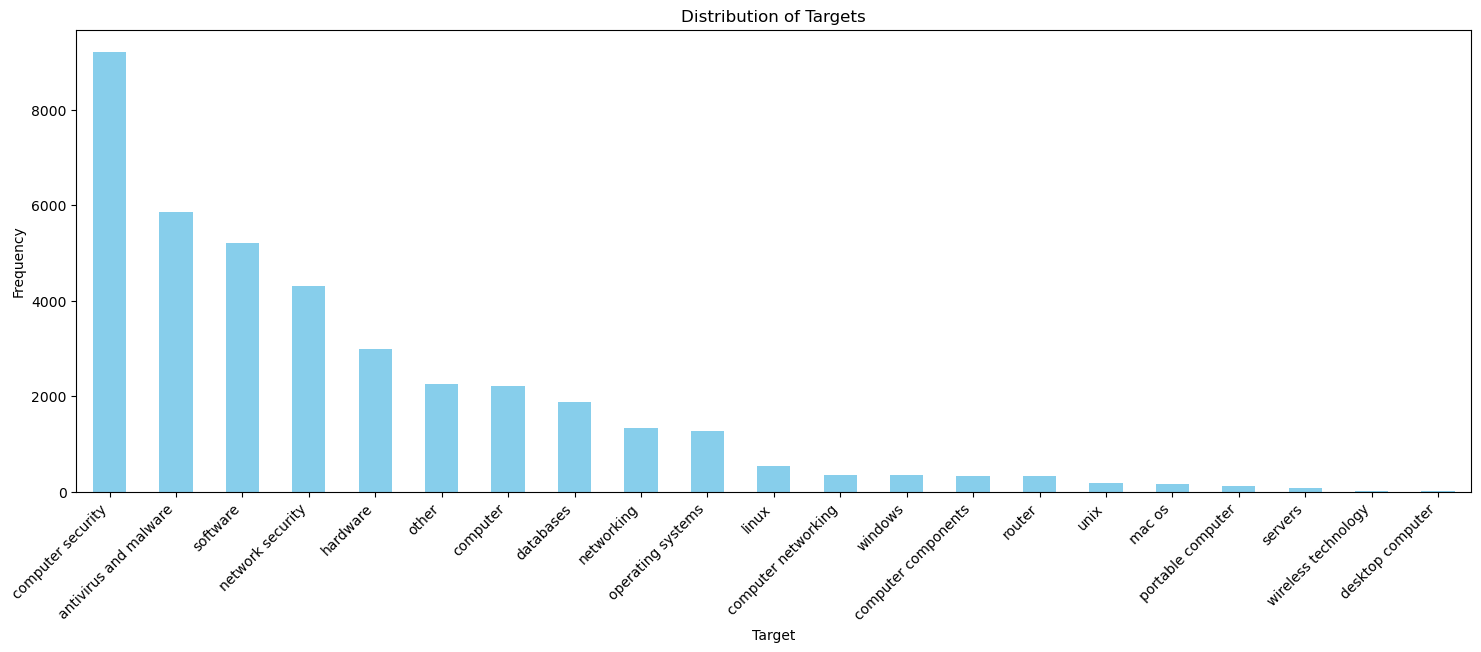

In [31]:
class_freq = Counter([item for sublist in categories_df['target'] for item in sublist])

print("Target Frequencies:")
for target, freq in class_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))
pd.Series(data=class_freq).sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

Target Frequencies:
('computer security', 'antivirus and malware'): 2316
('other',): 2255
('network security', 'computer security'): 2082
('software',): 715
('network security', 'computer security', 'antivirus and malware'): 704
('software', 'computer security', 'antivirus and malware'): 554
('computer', 'hardware'): 489
('computer', 'computer security', 'hardware', 'antivirus and malware'): 465
('software', 'databases'): 457
('software', 'databases', 'computer security', 'antivirus and malware'): 414
('networking',): 382
('software', 'network security', 'computer security'): 369
('software', 'databases', 'network security', 'computer security'): 307
('software', 'computer', 'hardware', 'antivirus and malware', 'computer security'): 256
('software', 'computer', 'hardware'): 182
('software', 'networking', 'computer security', 'antivirus and malware'): 155
('computer components', 'hardware'): 148
('networking', 'computer security', 'antivirus and malware'): 128
('software', 'networking')

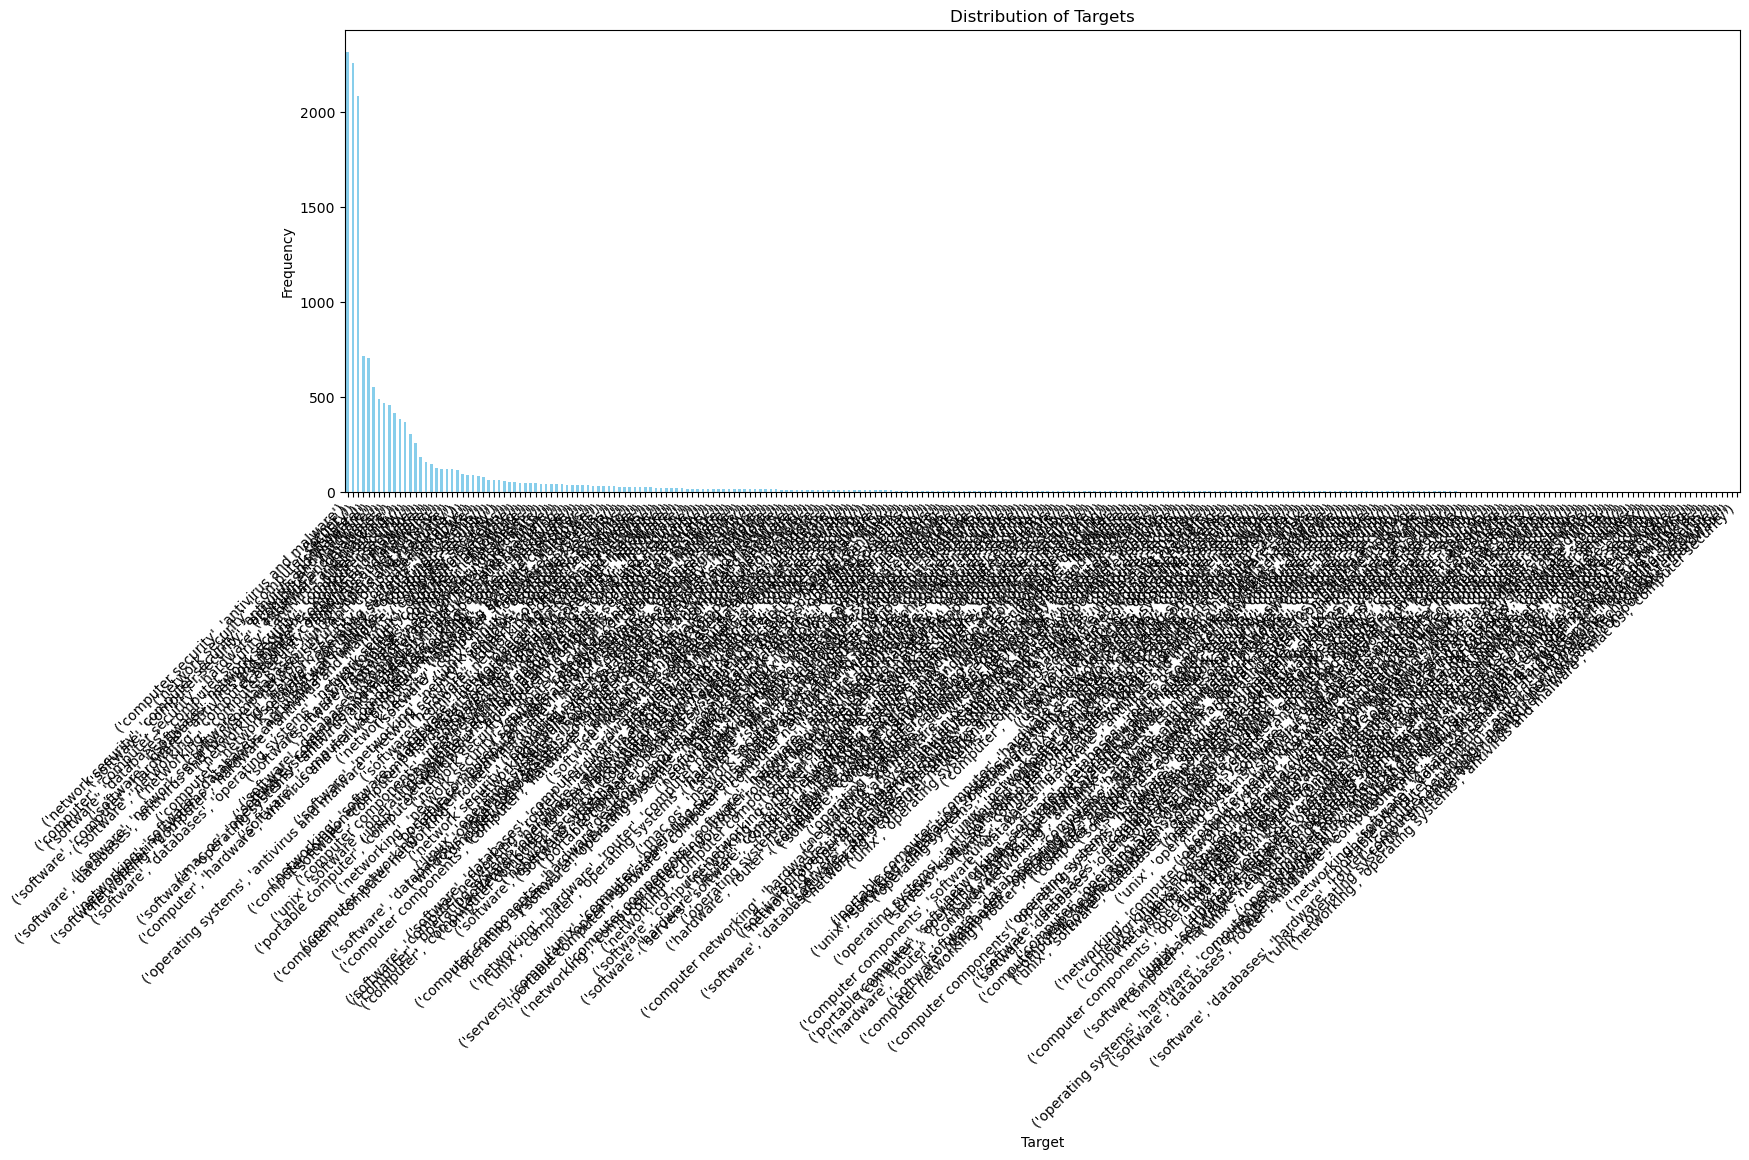

Number of targets to subsample:	168


In [34]:
target_freq = Counter(tuple(item) for item in categories_df['target'])
cut = len(target_freq)

print("Target Frequencies:")
for target, freq in target_freq.most_common()[:cut]:
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))

(pd.Series(data={str(k): v for k, v in target_freq.most_common()[:cut]})
 .sort_values(ascending=False)
 .plot(kind='bar', color='skyblue'))

plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()
print(f'Number of targets to subsample:\t{sum([1 if v < 10 else 0 for v in target_freq.values()])}')

In [35]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y=categories_df['target'])
labels_map, _ = np.unique(ar=y, axis=0, return_inverse=True)

Target Frequencies:
('computer security', 'antivirus and malware'): 2316
('other',): 2255
('network security', 'computer security'): 2082
('software',): 715
('network security', 'computer security', 'antivirus and malware'): 704
('software', 'computer security', 'antivirus and malware'): 554
('computer', 'hardware'): 489
('computer', 'computer security', 'hardware', 'antivirus and malware'): 465
('software', 'databases'): 457
('software', 'databases', 'computer security', 'antivirus and malware'): 414
('networking',): 382
('software', 'network security', 'computer security'): 369
('software', 'databases', 'network security', 'computer security'): 307
('software', 'computer', 'hardware', 'antivirus and malware', 'computer security'): 256
('software', 'computer', 'hardware'): 182
('software', 'networking', 'computer security', 'antivirus and malware'): 155
('computer components', 'hardware'): 148
('networking', 'computer security', 'antivirus and malware'): 128
('software', 'networking')

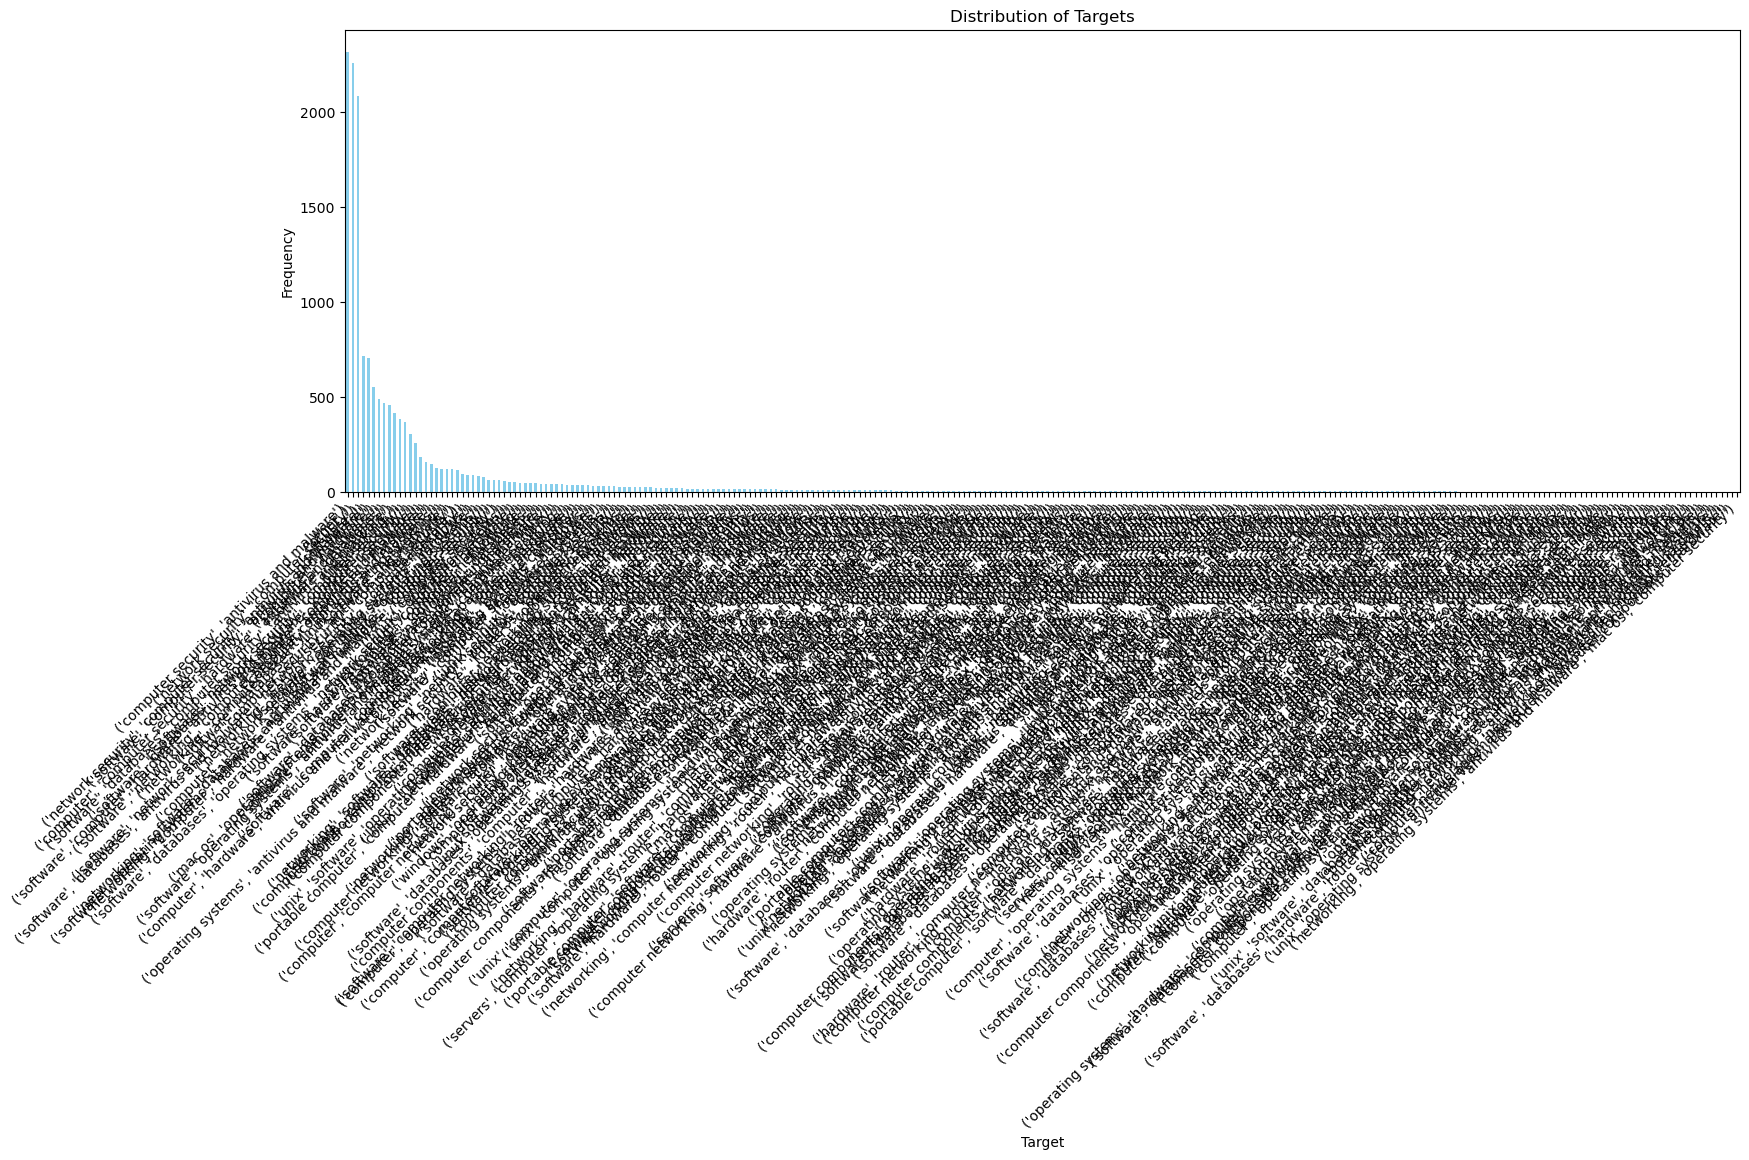

Updated Target Frequencies:
('computer security', 'antivirus and malware'): 2316
('other',): 2255
('network security', 'computer security'): 2082
('software',): 715
('network security', 'computer security', 'antivirus and malware'): 704
('software', 'computer security', 'antivirus and malware'): 554
('computer', 'hardware'): 489
('computer', 'computer security', 'hardware', 'antivirus and malware'): 465
('software', 'databases'): 457
('software', 'databases', 'computer security', 'antivirus and malware'): 414
('networking',): 382
('software', 'network security', 'computer security'): 369
('software', 'databases', 'network security', 'computer security'): 307
('software', 'computer', 'hardware', 'antivirus and malware', 'computer security'): 256
('software', 'computer', 'hardware'): 182
('software', 'networking', 'computer security', 'antivirus and malware'): 155
('computer components', 'hardware'): 148
('networking', 'computer security', 'antivirus and malware'): 128
('software', 'netw

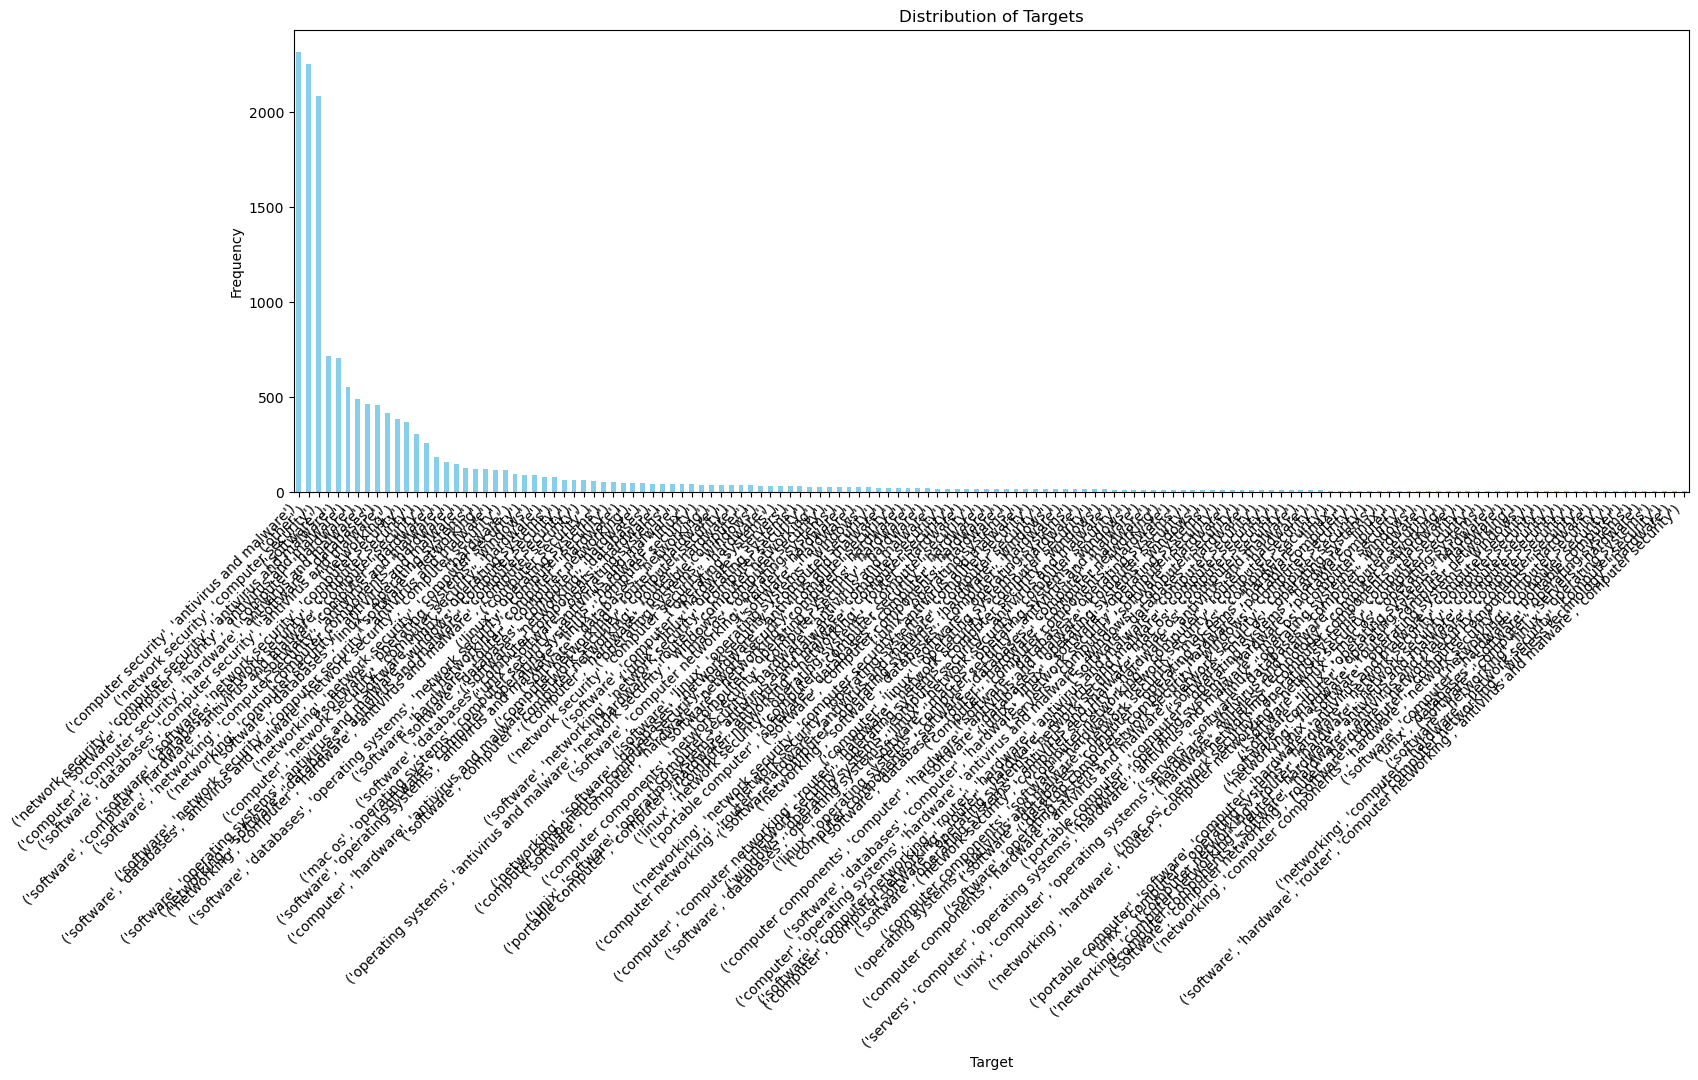

In [36]:
target_freq = Counter(tuple(item) for item in categories_df['target'])

print("Target Frequencies:")
for target, freq in target_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))
(pd.Series(data={str(k): v for k, v in target_freq.items()})
 .sort_values(ascending=False)
 .plot(kind='bar', color='skyblue'))
plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

valid_targets = {target for target, freq in target_freq.items() if freq >= 5}

# Filter the DataFrame to keep only valid targets
categories_df = categories_df[categories_df['target'].apply(lambda x: tuple(x) in valid_targets)]

# Reset the index (optional)
categories_df = categories_df.reset_index(drop=True)

# Print the updated target frequencies
updated_target_freq = Counter(tuple(item) for item in categories_df['target'])
print("Updated Target Frequencies:")
for target, freq in updated_target_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))
(pd.Series(data={str(k): v for k, v in updated_target_freq.items()})
 .sort_values(ascending=False)
 .plot(kind='bar', color='skyblue'))
plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

In [38]:
_, y_mcp = np.unique(ar=mlb.transform(categories_df['target']), axis=0, return_inverse=True)
X_train_val, X_test = train_test_split(
    categories_df,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y_mcp
)

In [39]:
with open(DATA_DIR / 'tweets-dataset' / 'categories_train.csv', 'wb') as f:
    X_train_val.to_csv(path_or_buf=f)

with open(DATA_DIR / 'tweets-dataset' / 'categories_test.csv', 'wb') as f:
    X_test.to_csv(path_or_buf=f)